C:\Users\Aamir Javaid\anaconda3\envs\xai\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\Aamir Javaid\anaconda3\envs\xai\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/10, Train Acc: 91.49%, Val Acc: 62.50%
Epoch 2/10, Train Acc: 93.10%, Val Acc: 56.25%
Epoch 3/10, Train Acc: 94.21%, Val Acc: 68.75%
Epoch 4/10, Train Acc: 94.27%, Val Acc: 81.25%
Epoch 5/10, Train Acc: 95.23%, Val Acc: 81.25%
Epoch 6/10, Train Acc: 94.82%, Val Acc: 81.25%
Epoch 7/10, Train Acc: 95.71%, Val Acc: 81.25%
Epoch 8/10, Train Acc: 94.82%, Val Acc: 87.50%
Epoch 9/10, Train Acc: 95.46%, Val Acc: 87.50%
Epoch 10/10, Train Acc: 96.11%, Val Acc: 87.50%

Classification Report:
              precision    recall  f1-score   support

      NORMAL       0.96      0.54      0.69       234
   PNEUMONIA       0.78      0.99      0.87       390

    accuracy                           0.82       624
   macro avg       0.87      0.76      0.78       624
weighted avg       0.85      0.82      0.80       624



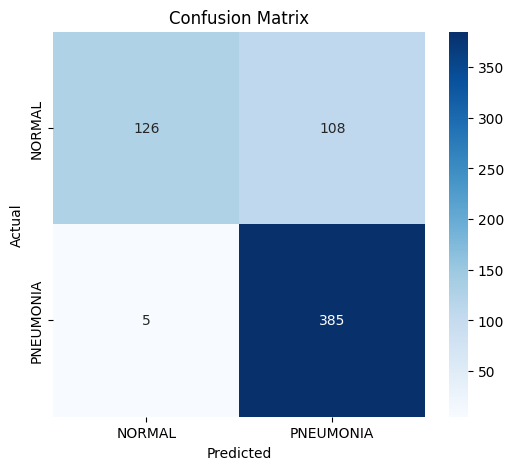

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision import datasets, models
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import os

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Data paths
data_dir = 'C:/Users/Aamir Javaid/Downloads/XAI_INT/chest_xray'

# Data transforms
transform = {
    'train': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor()
    ]),
    'val': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor()
    ]),
    'test': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor()
    ])
}

# Datasets and loaders
image_datasets = {
    x: datasets.ImageFolder(os.path.join(data_dir, x), transform[x])
    for x in ['train', 'val', 'test']
}

dataloaders = {
    x: DataLoader(image_datasets[x], batch_size=32, shuffle=True)
    for x in ['train', 'val']
}
test_loader = DataLoader(image_datasets['test'], batch_size=32, shuffle=False)

# Class names
class_names = image_datasets['train'].classes

# Load pre-trained ResNet18 and modify
model = models.resnet18(pretrained=True)
for param in model.parameters():
    param.requires_grad = False

num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 2)  # 2 classes: NORMAL, PNEUMONIA
model = model.to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=0.001)

# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in dataloaders['train']:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    val_loss = 0.0
    val_correct = 0
    val_total = 0
    model.eval()
    with torch.no_grad():
        for images, labels in dataloaders['val']:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

    print(f"Epoch {epoch+1}/{num_epochs}, "
          f"Train Acc: {100*correct/total:.2f}%, "
          f"Val Acc: {100*val_correct/val_total:.2f}%")

# Evaluation
model.eval()
y_true = []
y_pred = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        y_true.extend(labels.numpy())
        y_pred.extend(predicted.cpu().numpy())

# Classification Report
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


### Classes Of Image Define

In [15]:
import os
from torchvision import datasets
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader
import torch
import numpy as np

# 1. Point to your data directories
data_dir = 'C:/Users/Aamir Javaid/Downloads/XAI_INT/chest_xray'
train_dir = os.path.join(data_dir, 'train')

# 2. Load with ImageFolder (we’ll apply ToTensor only so we can inspect raw pixel stats)
train_ds = datasets.ImageFolder(train_dir, transform=ToTensor())

# 3. Basic structure
print(f"→ Classes: {train_ds.classes}")            # ['NORMAL', 'PNEUMONIA']


→ Classes: ['NORMAL', 'PNEUMONIA']


In [3]:
from torchvision import transforms
import torchvision.transforms.functional as F
import random

def apply_clahe(img):
    # Convert back to PIL, apply CLAHE on each channel, convert to tensor
    import numpy as np
    from PIL import Image, ImageOps
    img_pil = transforms.ToPILImage()(img)
    # CLAHE via PIL’s ImageOps
    # Note: PIL doesn’t have CLAHE built-in; you can use OpenCV or skimage if available
    return transforms.ToTensor()(img_pil)

train_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.RandomHorizontalFlip(),
    # 50% chance of basic contrast jitter
    transforms.RandomApply([
        transforms.ColorJitter(brightness=0.1, contrast=0.5)
    ], p=0.5),
    # 30% chance of more extreme contrast jitter
    transforms.RandomApply([
        transforms.ColorJitter(brightness=0.2, contrast=1.0)
    ], p=0.3),
    # Optional: 20% chance of CLAHE (if you implement via cv2 or skimage)
    transforms.RandomApply([transforms.Lambda(lambda img: apply_clahe(img))], p=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])


# Initial statistics

In [9]:
import os, glob
from PIL import Image
import numpy as np

# 1. Grab all images (adjust extensions as needed)
root = r"C:/Users/Aamir Javaid/Downloads/XAI_INT/chest_xray"
image_paths = glob.glob(os.path.join(root, "**", "*.jpg"),   recursive=True) \
            + glob.glob(os.path.join(root, "**", "*.jpeg"), recursive=True) \
            + glob.glob(os.path.join(root, "**", "*.png"),  recursive=True)

# 2. Load sizes
sizes = [Image.open(p).size for p in image_paths]  # .size returns (width, height)

# 3. Split into arrays
widths, heights = zip(*sizes)
w = np.array(widths)
h = np.array(heights)

# 4. Compute stats
print("Width  → mean:  {:.1f}, median: {:.1f}, std: {:.1f}".format(
      w.mean(), np.median(w), w.std()))
print("Height → mean:  {:.1f}, median: {:.1f}, std: {:.1f}".format(
      h.mean(), np.median(h), h.std()))

# (Optional) stats on image area in pixels
areas = w * h
print("Area   → mean:  {:.0f}, median: {:.0f}, std: {:.0f}".format(
      areas.mean(), np.median(areas), areas.std()))


Width  → mean:  1327.9, median: 1281.0, std: 363.5
Height → mean:  970.7, median: 888.0, std: 383.4
Area   → mean:  1418909, median: 1136928, std: 970360


## Heatmap of chest X-rays for Phnemonia Detection

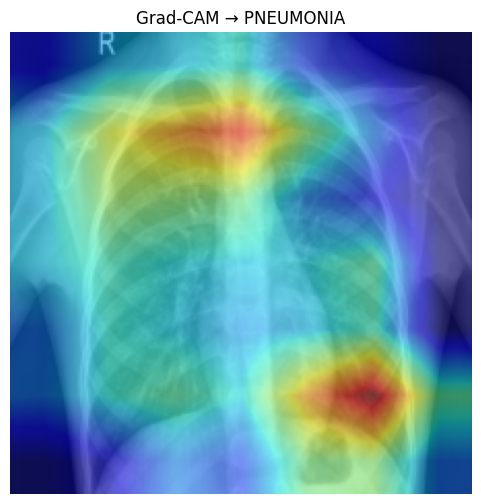

In [13]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F

# ------ Grad-CAM ------
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.activations = None
        # hook the target conv layer
        target_layer.register_forward_hook(self._hook)

    def _hook(self, module, input, output):
        # save the activations and ask PyTorch to retain their grads
        self.activations = output
        output.retain_grad()

    def __call__(self, x, class_idx=None):
        # ensure our input will propagate gradients
        x.requires_grad_()
        self.model.zero_grad()
        out = self.model(x)  # forward pass

        if class_idx is None:
            class_idx = out.argmax(dim=1).item()

        # backprop the score for that class
        score = out[0, class_idx]
        score.backward()

        # pull out the feature‐map and its gradient
        acts  = self.activations[0].cpu().detach().numpy()     # shape [C, h, w]
        grads = self.activations.grad[0].cpu().detach().numpy() # same shape

        # weight each channel by the mean gradient
        weights = grads.mean(axis=(1,2))                       # [C]
        cam = np.zeros(acts.shape[1:], dtype=np.float32)       # [h, w]
        for w, a in zip(weights, acts):
            cam += w * a

        # relu + normalize
        cam = np.maximum(cam, 0)
        cam -= cam.min()
        cam /= cam.max()
        return cam  # [h, w] in [0,1]

# ------ Heatmap Overlay ------
def overlay_heatmap(img, mask, alpha=0.5):
    """
    img: HxWx3 numpy array in [0,1]
    mask: hxw numpy array in [0,1]
    """
    # upsample mask to image size
    mask_t = torch.tensor(mask)[None,None]
    mask_up = F.interpolate(mask_t, size=img.shape[:2],
                            mode='bilinear', align_corners=False)[0,0].numpy()
    heatmap = plt.get_cmap('jet')(mask_up)[:, :, :3]
    return np.clip(heatmap * alpha + img * (1 - alpha), 0, 1)

# ------ Usage Example ------
# (Assumes model, test_loader, device & class_names are already defined)

grad_cam = GradCAM(model, model.layer4[1].conv2)

# grab one batch & image
images, _ = next(iter(test_loader))
inp = images[0].unsqueeze(0).to(device)

# compute cam mask
mask = grad_cam(inp)

# prepare original (H,W,3) image in [0,1]
orig = images[0].permute(1,2,0).cpu().numpy()

# overlay & display
cam_img = overlay_heatmap(orig, mask, alpha=0.5)
plt.figure(figsize=(6,6))
plt.imshow(cam_img)
plt.axis('off')
plt.title(f"Grad-CAM → {class_names[model(inp).argmax().item()]}")
plt.show()


In [ ]:
from collections import Counter

size_counts = Counter(sizes)
mode_size, mode_count = size_counts.most_common(1)[0]
outliers = [s for s, cnt in size_counts.items() if s != mode_size]

print("Most common size:", mode_size, "(", mode_count, "images )")
print("Other sizes (to review):", outliers)


## Identify and remove unreadable / missing files

In [10]:
from PIL import Image #Identify and remove unreadable / missing files
valid_paths = []
for p in data_dir:
    try:
        _ = Image.open(p).verify()  # will raise if file’s corrupt
        valid_paths.append(p)
    except Exception:
        print(f"Removing unreadable image: {p}")
# Now work only with valid_paths


Removing unreadable image: C
Removing unreadable image: :
Removing unreadable image: /
Removing unreadable image: U
Removing unreadable image: s
Removing unreadable image: e
Removing unreadable image: r
Removing unreadable image: s
Removing unreadable image: /
Removing unreadable image: A
Removing unreadable image: a
Removing unreadable image: m
Removing unreadable image: i
Removing unreadable image: r
Removing unreadable image:  
Removing unreadable image: J
Removing unreadable image: a
Removing unreadable image: v
Removing unreadable image: a
Removing unreadable image: i
Removing unreadable image: d
Removing unreadable image: /
Removing unreadable image: D
Removing unreadable image: o
Removing unreadable image: w
Removing unreadable image: n
Removing unreadable image: l
Removing unreadable image: o
Removing unreadable image: a
Removing unreadable image: d
Removing unreadable image: s
Removing unreadable image: /
Removing unreadable image: X
Removing unreadable image: A
Removing unrea

In [16]:
images = []
for batch_number, (inputs, targets) in enumerate(test_loader):
    images.append(inputs)
images = torch.cat(images, dim=0).detach().cpu().numpy()

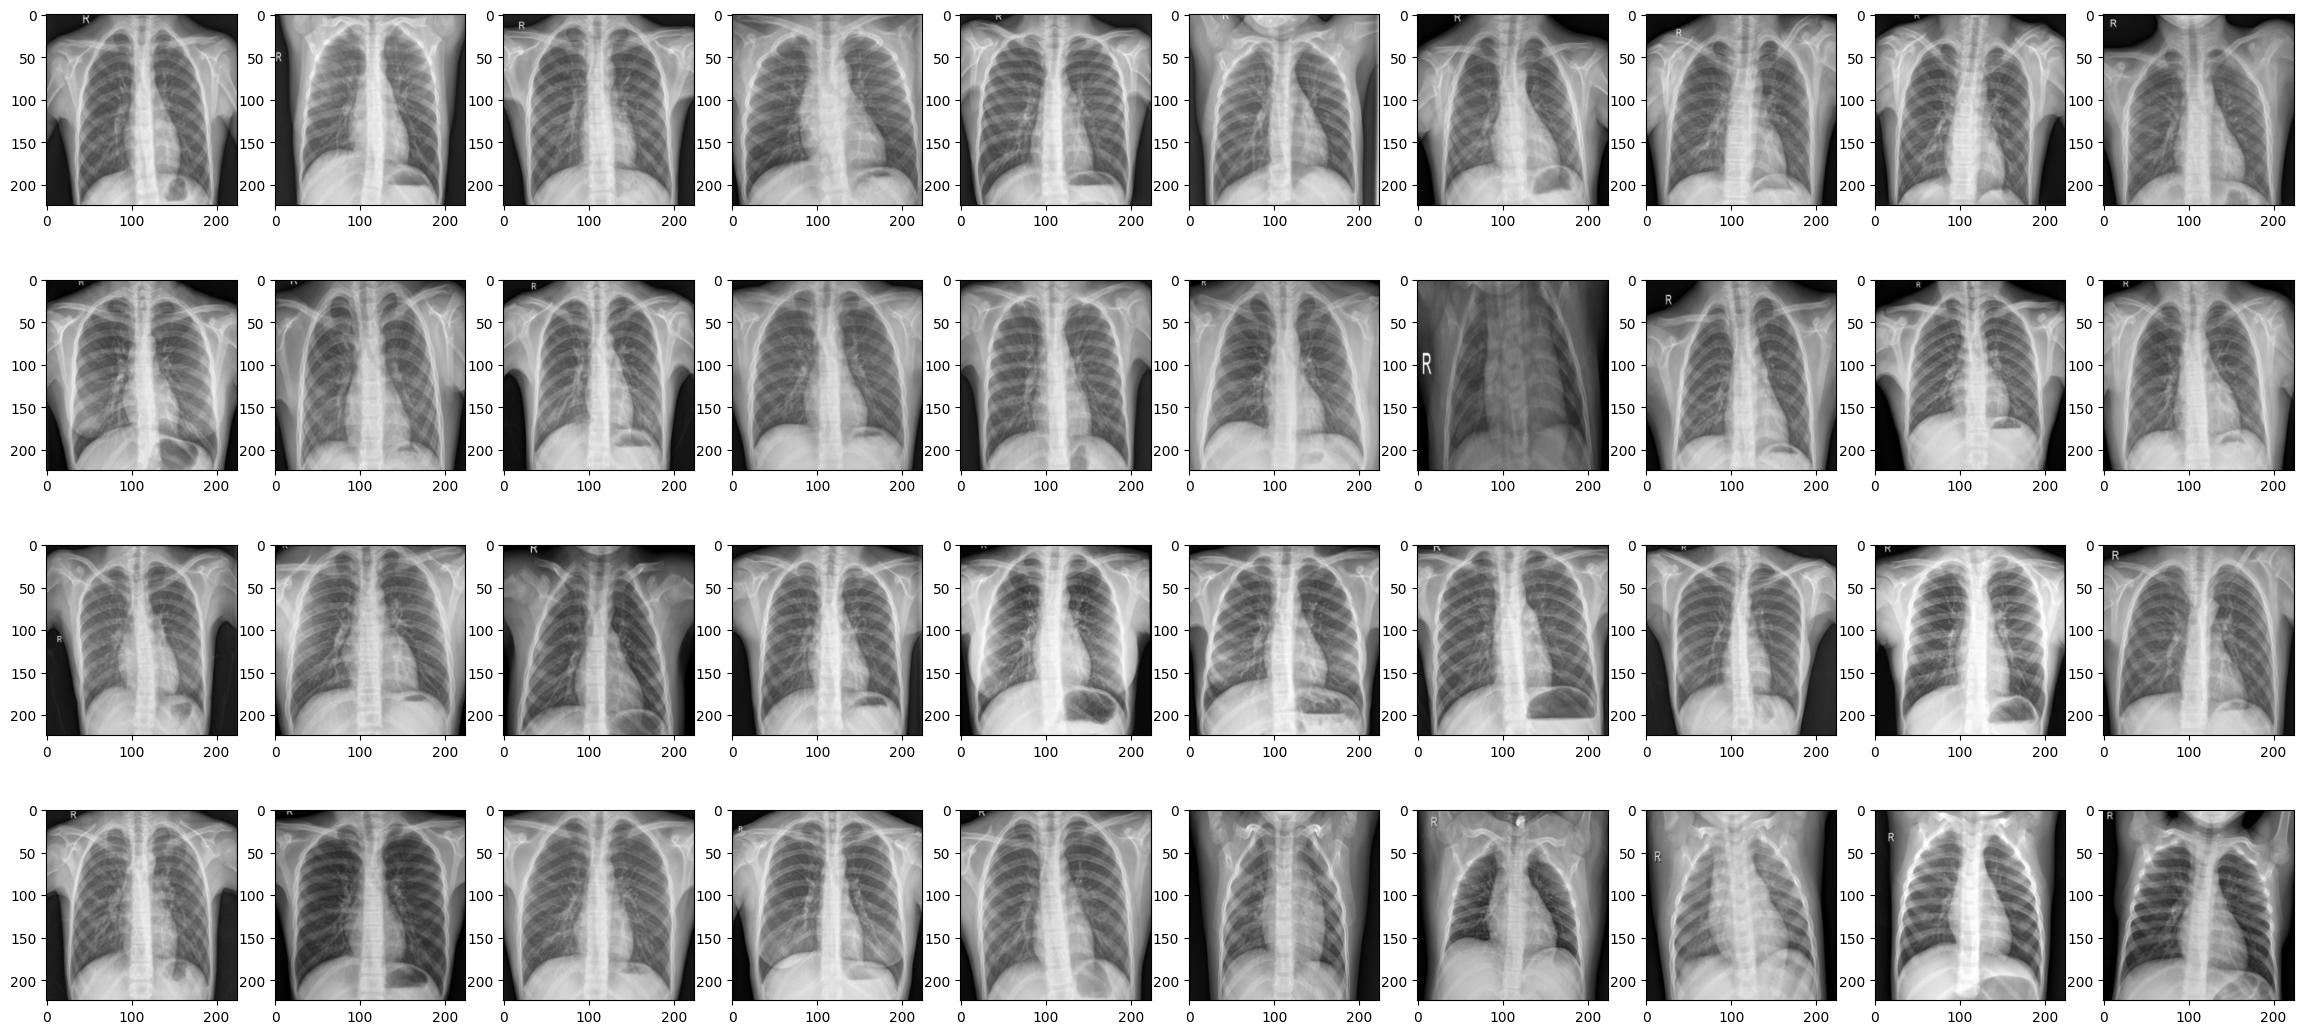

In [17]:
n_rows = 4
n_cols = 10

fig, axs = plt.subplots(n_rows, n_cols, figsize=(2.9*n_cols, n_rows*3.3))
for i in range(n_rows*n_cols):
    axs[i//n_cols][i%n_cols].imshow(images[i].transpose(1,2,0))
plt.grid(visible=False)